In [1]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StringType, IntegerType, ArrayType, FloatType, DataType
import pyspark.sql.functions as fn
from pyspark.sql.functions import udf, size, avg, count, col,sum, explode
from operator import itemgetter
import json, datetime

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext


In [2]:
# s3_path = 's3a://mist-secorapp-production/ap-stats-analytics/ap-stats-analytics-production/' + DATE + '/*'

DATE = 'dt=2019-11-13'
s3_path = 's3://mist-data-science-dev/wenfeng/rrm/{date}/*'.format(date=DATE)
df_t = spark.read.parquet(s3_path)

In [3]:
df_pd = df_t.toPandas()

In [4]:
df_pd.head()

,ap_id,when,dev,num_active_clients,band,channel,utilization_all,utilization_rx_other_bss,utilization_non_wifi,utilization_unknown_wifi
0,5c-5b-35-be-62-ac,1573633942191377,r0,1,24,9,0.531569,0.244362,0.124771,0.074815
1,5c-5b-35-be-62-ac,1573633942191377,r1,23,5,52,0.158260,0.013059,0.000315,0.021947
2,5c-5b-35-be-62-ac,1573633942191377,r2,0,24,165,0.000000,0.000000,0.000000,0.000000
3,5c-5b-35-be-62-ac,1573634004191350,r0,1,24,9,0.563127,0.259851,0.129641,0.072887
4,5c-5b-35-be-62-ac,1573634004191350,r1,25,5,52,0.165590,0.014058,0.000559,0.011471


In [5]:
import matplotlib as mpl
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import pandas as pd

df_pd['datetime'] = [ pd.Timestamp(x*1000) for x in df_pd['when']]

In [6]:
df_pd[df_pd['when']<1573582350191725]

,ap_id,when,dev,num_active_clients,band,channel,utilization_all,utilization_rx_other_bss,utilization_non_wifi,utilization_unknown_wifi,datetime


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1264c50d0>,
      dtype=object)

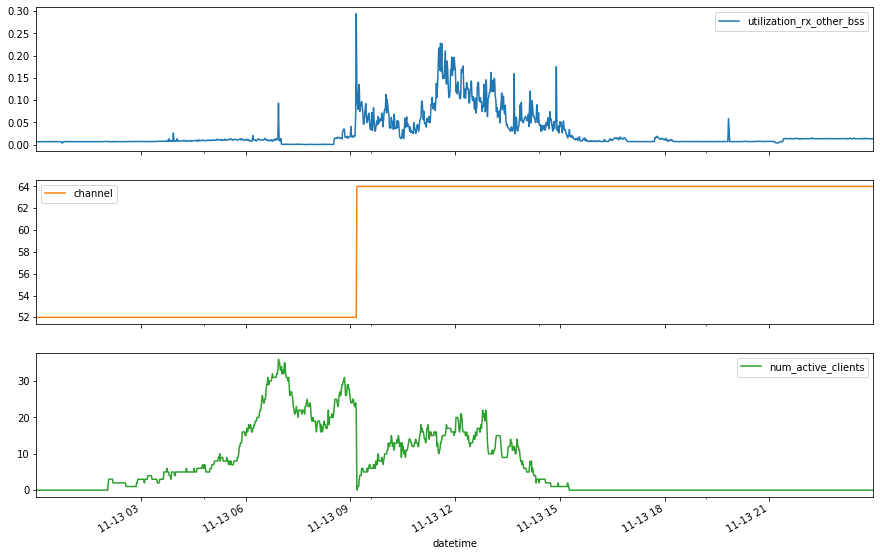

In [15]:
df_pd[df_pd['dev']=="r1"].plot(x="datetime", y=["utilization_rx_other_bss", "channel", "num_active_clients"], figsize=(15, 10), subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11592ec90>,
      dtype=object)

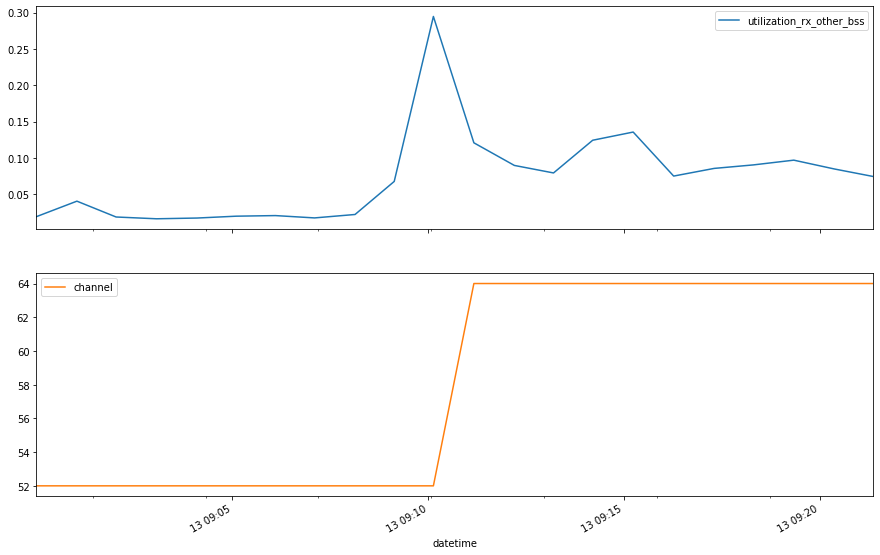

In [8]:


ds_filter = (df_pd['dev']=="r1")&(df_pd['datetime']>"2019-11-13 09:00:00.191341")&(df_pd['datetime']<"2019-11-13 09:22:00.191341")
df_pd[ds_filter].plot(x="datetime", y=["utilization_rx_other_bss", "channel"], figsize=(15, 10), subplots=True)
      
      

In [9]:
columns = ['datetime', 'channel', 'utilization_rx_other_bss', 'utilization_non_wifi',       'utilization_unknown_wifi']
df_pd[ds_filter][columns].sort_values(by=['datetime'])
# df_pd.columns

,datetime,channel,utilization_rx_other_bss,utilization_non_wifi,utilization_unknown_wifi
1279,2019-11-13 09:00:00.219217,52,0.019423,0.000537,0.016448
1282,2019-11-13 09:01:02.191347,52,0.040693,0.001373,0.031992
1285,2019-11-13 09:02:02.194522,52,0.018927,0.000646,0.015552
1288,2019-11-13 09:03:04.196471,52,0.016475,0.001070,0.015496
1291,2019-11-13 09:04:06.191358,52,0.017498,0.001152,0.016023
1294,2019-11-13 09:05:06.191375,52,0.020046,0.001558,0.022182
724,2019-11-13 09:06:06.194693,52,0.020867,0.001380,0.027081
727,2019-11-13 09:07:06.198075,52,0.017668,0.002781,0.031003
730,2019-11-13 09:08:08.191338,52,0.022381,0.004707,0.044331
733,2019-11-13 09:09:08.191354,52,0.067812,0.001546,0.045660


/opt/mistsys/ds_incubator/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


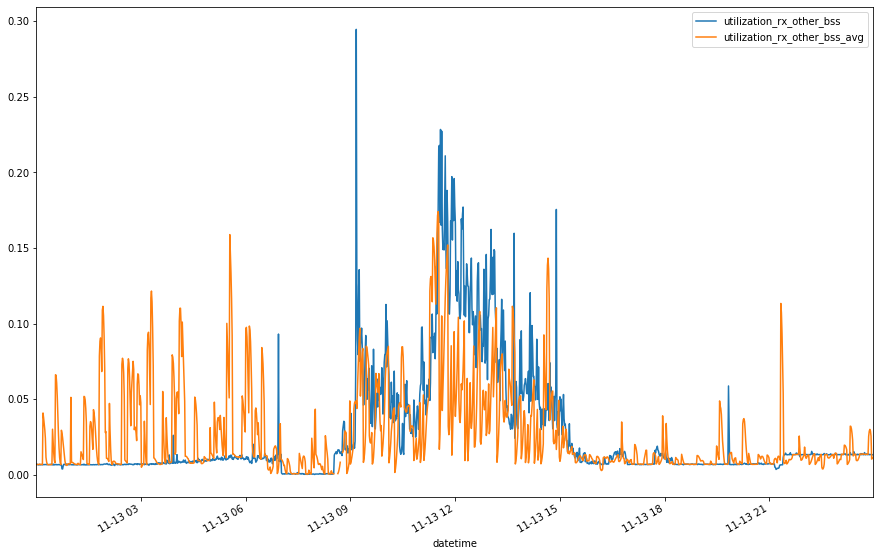

In [10]:
# df_pd.sort_values(by=['datetime'])
df_r1 = df_pd[df_pd['dev']=="r1"]

df_r1["utilization_rx_other_bss_avg"] = df_r1['utilization_rx_other_bss'].rolling(window=10, win_type ='triang').mean()
df_r1.plot(x="datetime", y=[ "utilization_rx_other_bss",  "utilization_rx_other_bss_avg"], figsize=(15, 10), subplots=False)


In [11]:
x0 = 0.0
wt = 0.1
xx = []
for x in df_r1["utilization_rx_other_bss"]:
    x0 += (x0-x) * wt
#     print(x0)
    xx.append(x0)
    
df_r1['util_avg']= xx
# (xx)

/opt/mistsys/ds_incubator/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


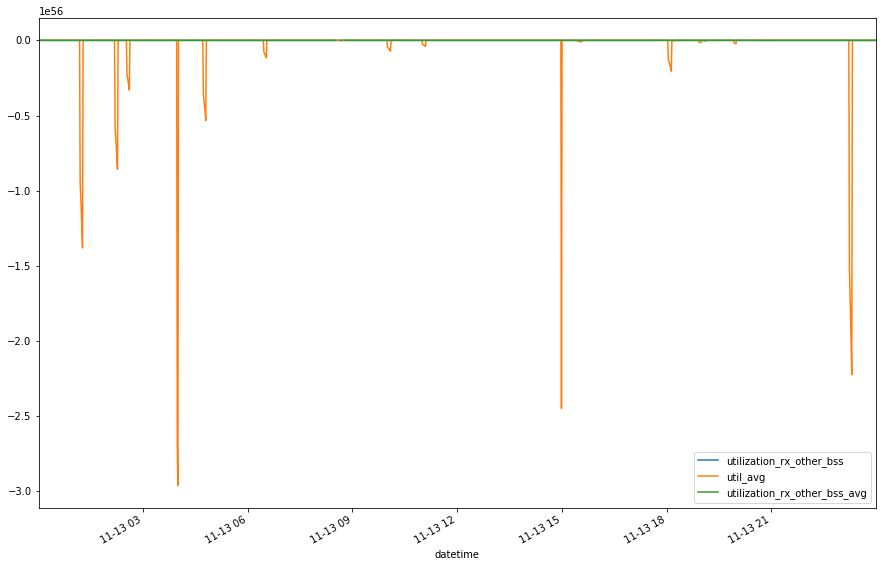

In [12]:
df_r1.plot(x="datetime", y=[ "utilization_rx_other_bss", "util_avg", "utilization_rx_other_bss_avg"], figsize=(15, 10), subplots=False)


In [13]:
df_r1[df_r1['datetime']<"2019-11-13 02:00:00.191341"][[ "utilization_rx_other_bss", "util_avg", "utilization_rx_other_bss_avg"]]

,utilization_rx_other_bss,util_avg,utilization_rx_other_bss_avg
865,0.006835,-1.175745e+10,0.043161
868,0.006785,-1.293319e+10,0.041132
871,0.006697,-1.422651e+10,0.037019
874,0.006806,-1.564917e+10,0.031188
877,0.006780,-1.721408e+10,0.024132
...,...,...,...
4192,0.006734,-9.436283e+55,0.007736
4195,0.006889,-1.037991e+56,0.007273
4198,0.006858,-1.141790e+56,0.006961
4201,0.006793,-1.255969e+56,0.006821


In [14]:
ds_filter = (df_pd['dev']=="r1")&(df_pd['datetime']>"2019-11-13 08:00:00.191341")&(df_pd['datetime']<"2019-11-13 10:22:00.191341")
df_pd[ds_filter].plot(x="datetime", y=["channel", "utilization_rx_other_bss",  "utilization_rx_other_bss_avg"], figsize=(15, 10), subplots=True)


KeyError: "['utilization_rx_other_bss_avg'] not in index"